# MNIST with Keras

This notebook uses Keras, a high-level neural network system, to build a model capable of identifying hand-written digits (0 - 9) with high accuracy.

This MNIST database contains 70,000 pictures of digits. Each picture is stored as a matrix of 28 x 28 pixels, whose values represent how dark the pixel is on a scale of 0 to 255. We'll use 60,000 of these samples to train the model, then evaluate its accuracy by testing it on remaining 10,000 samples.

In [60]:
# Our model is a sequential stack of CNN layers
from keras.models import Sequential

# "Core" layers of Keras
from keras.layers import Dense, Dropout, Activation, Flatten

# CNN layers
from keras.layers import Convolution2D, MaxPooling2D

# Datasets and Utils
from keras.utils import np_utils
from keras.datasets import mnist

# Numpy and Pandas
import pandas as pd
import numpy as np
np.random.seed(123)

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## Input Data

In [61]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train (capital X for matrix) contains our 60,000 train samples. <b>

In [62]:
X_train.shape

(60000, 28, 28)

60,000 samples that are 28 x 28 pixels each. Let's plot one as an example

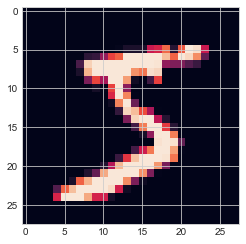

In [63]:
plt.imshow(X_train[0]);

### Preprocess Data

Tensorflow requires we declare a dimension for the _depth_ of the input image. A full-color image with 3 **RGB** channels would have a depth of 3. Our black and white pixel image has a depth of 1.

Transform the dataset from (n, width, height) to (n, width, height, depth)

In [64]:
num_train_samples, img_rows, img_cols = X_train.shape

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

# Input shape of a single image
input_shape = (img_rows, img_cols, 1)
X_train.shape

(60000, 28, 28, 1)

In [65]:
# Declare the types for our inputs
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize dataset to be between 0 and 1. MNIST uses 255 as a maximum value
print np.max(X_train)
X_train /= 255
X_test /= 255

255.0


### Preprocess Labels

In [66]:
print y_train.shape
y_train[:10]

(60000,)


array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

The data is in a typical format for machine learning. It is a list of labels, one for each samples in X_train. Keras requires we reshape the data into 10 distinct classes, one for each digit.

In [67]:
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [68]:
Y_train.shape

(60000, 10)

In [69]:
Y_train[:10]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

The first row corresponds to '5', the next row to '0', and the next row to '4', which matches our first array. This is typically called "One Hot Encoding", where _categorical_ features are turned into binary vectors of 0's and 1's.

### Define Model Architecture

In [70]:
model = Sequential()

In [71]:
model.add(Convolution2D(filters=32, 
                        kernel_size=(3, 3), 
                        activation='relu', 
                        input_shape=(28,28, 1)))

Filters is an integer that represents the dimensionality of the output space. The kernel_size specifies the width and height of the 2D convolution window.

Add more layers to the model

In [72]:
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

/Users/Jvivian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  if __name__ == '__main__':


The **Dropout** layer is an important method for regularizing the model to prevent overfitting. Explanation [here](https://www.quora.com/How-does-the-dropout-method-work-in-deep-learning-And-why-is-it-claimed-to-be-an-effective-trick-to-improve-your-network).

MaxPooling2D is a way to reduce the number of parameters in our model by sliding a 2x2 pooling filter across the previous layer and taking the max of the 4 values in the 2x2 filter.

So far, for model parameters, we've added two Convolution layers. To complete our model architecture, let's add a fully connected layer and then the output layer:

In [73]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

For Dense layers, the first parameter is the output size of the layer. Keras automatically handles the connections between layers.

Note that the final layer has an output size of 10, corresponding to the 10 classes of digits.

Also note that the weights from the Convolution layers must be flattened (made 1-dimensional) before passing them to the fully connected Dense layer.

### Compile Model

Compiling the model just means specifying a loss function and optimizer

In [74]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Fit Model on Training Data

In [79]:
model.fit(X_train, Y_train, 
          batch_size=128, 
          epochs=12, 
          verbose=1,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 145s - loss: 0.2525 - acc: 0.9238 - val_loss: 0.0566 - val_acc: 0.9806
Epoch 2/12
60000/60000 [==============================] - 135s - loss: 0.0968 - acc: 0.9706 - val_loss: 0.0415 - val_acc: 0.9855
Epoch 3/12
60000/60000 [==============================] - 133s - loss: 0.0736 - acc: 0.9780 - val_loss: 0.0370 - val_acc: 0.9879
Epoch 4/12
60000/60000 [==============================] - 147s - loss: 0.0610 - acc: 0.9812 - val_loss: 0.0346 - val_acc: 0.9882
Epoch 5/12
60000/60000 [==============================] - 131s - loss: 0.0544 - acc: 0.9833 - val_loss: 0.0310 - val_acc: 0.9897
Epoch 6/12
60000/60000 [==============================] - 140s - loss: 0.0457 - acc: 0.9859 - val_loss: 0.0314 - val_acc: 0.9901
Epoch 7/12
60000/60000 [==============================] - 137s - loss: 0.0433 - acc: 0.9862 - val_loss: 0.0324 - val_acc: 0.9897
Epoch 8/12
60000/60000 [=======================

Score the model

In [83]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', round(score[0], 4))
print('Test accuracy:', round(score[1], 4))

('Test loss:', 0.029)
('Test accuracy:', 0.9915)


### Closer Look

To understand what is being evaluated by **Test Accuracy**, let's look at a single example from our X_test

In [86]:
index = 50
print y_test[50]

6


The 50th sample in our test set is for the number 6. Let's see what it looks like

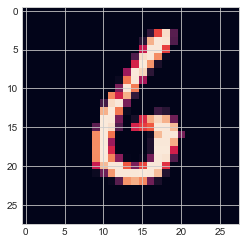

In [121]:
# Because our dimensions are 60.000, 28, 28, and 1, we select the 50th sample as follows:
# 50 for the 50th sample. ":" means all values, so all values for width and height, then 0 at the end for that dim.
plt.imshow(X_test[50,:,:,0]);

Plugging this sample into our model, it will give us confidence scores for how likely it thinks each number is

In [118]:
# I use the clunky syntax [50:51] to select a single sample but retain the dimensionality
# X_test[50] returns a (28 x 28 x 1) vector but our model requires an (n x 28 x 28 x 1) tensor
for i, j in zip(xrange(10), model.predict(X_test[50:51])[0]):
    print 'Digit: {}\t Probability: {}'.format(i, j)

Digit: 0	 Probability: 3.6093805722e-09
Digit: 1	 Probability: 3.45599200299e-13
Digit: 2	 Probability: 2.7453649163e-12
Digit: 3	 Probability: 2.5316632471e-12
Digit: 4	 Probability: 4.57789986474e-11
Digit: 5	 Probability: 2.28169909633e-08
Digit: 6	 Probability: 1.0
Digit: 7	 Probability: 1.76142383217e-18
Digit: 8	 Probability: 1.28835608848e-10
Digit: 9	 Probability: 2.94866724353e-13


Dope!